# 3.3 Off-Policy Estimator based on the Conjunct Effect Model(OffCEM)推定量
参考文献
- Yuta Saito, Qingyang Ren, and Thorsten Joachims. [Off-Policy Evaluation for Large Action Spaces via Conjunct Effect Modeling](https://arxiv.org/abs/2305.08062). ICML2023.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_ips, calc_mips, calc_offcem
from utils import eps_greedy_policy, aggregate_simulation_results, remove_outliers

### あえて用いない行動特徴量の次元数を変化させたときのIPS・MIPS・OffCEM推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [2]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_actions = 1000 # 行動数, |A|
num_clusters = 990 # 行動クラスタ数
num_data = 1000 # ログデータのサイズ
random_state = 12345
lambda_ = 0.5 # クラスタ効果と残差効果の配合率
beta = -0.1 # データ収集方策のパラメータ
random_ = check_random_state(random_state)
num_replace_clusters_list = [0, 100, 300, 500, 700, 900] # あえて用いない行動特徴量の次元数

In [3]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
phi_a = np.tile(np.arange(num_clusters), 100)[:num_actions]
theta_g = random_.normal(size=(dim_context, num_clusters))
M_g = random_.normal(size=(dim_context, num_clusters))
b_g = random_.normal(size=(1, num_clusters))
theta_h = random_.normal(size=(dim_context, num_actions))
M_h = random_.normal(size=(dim_context, num_actions))
b_h = random_.normal(size=(1, num_actions))
for num_replace_clusters in num_replace_clusters_list:
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters,
        lambda_=lambda_, phi_a=phi_a,
        theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_replace_clusters={num_replace_clusters}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_, beta=beta,
            theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, random_state = _,
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["q_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["ips"] = calc_ips(offline_logged_data, pi)
        estimated_policy_values["mips"] = calc_mips(offline_logged_data, pi, replace_c=num_replace_clusters)
        q_hat = offline_logged_data["h_x_a"] + random_.normal(size=(num_data, num_actions))
        estimated_policy_values["offcem"] = calc_offcem(offline_logged_data, pi, q_hat, replace_c=num_replace_clusters)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_replace_clusters", num_replace_clusters,
        )
    )
result_df_num_replace_clusters = pd.concat(result_df_list).reset_index(level=0)

num_replace_clusters=900...: 100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


## 図3.15

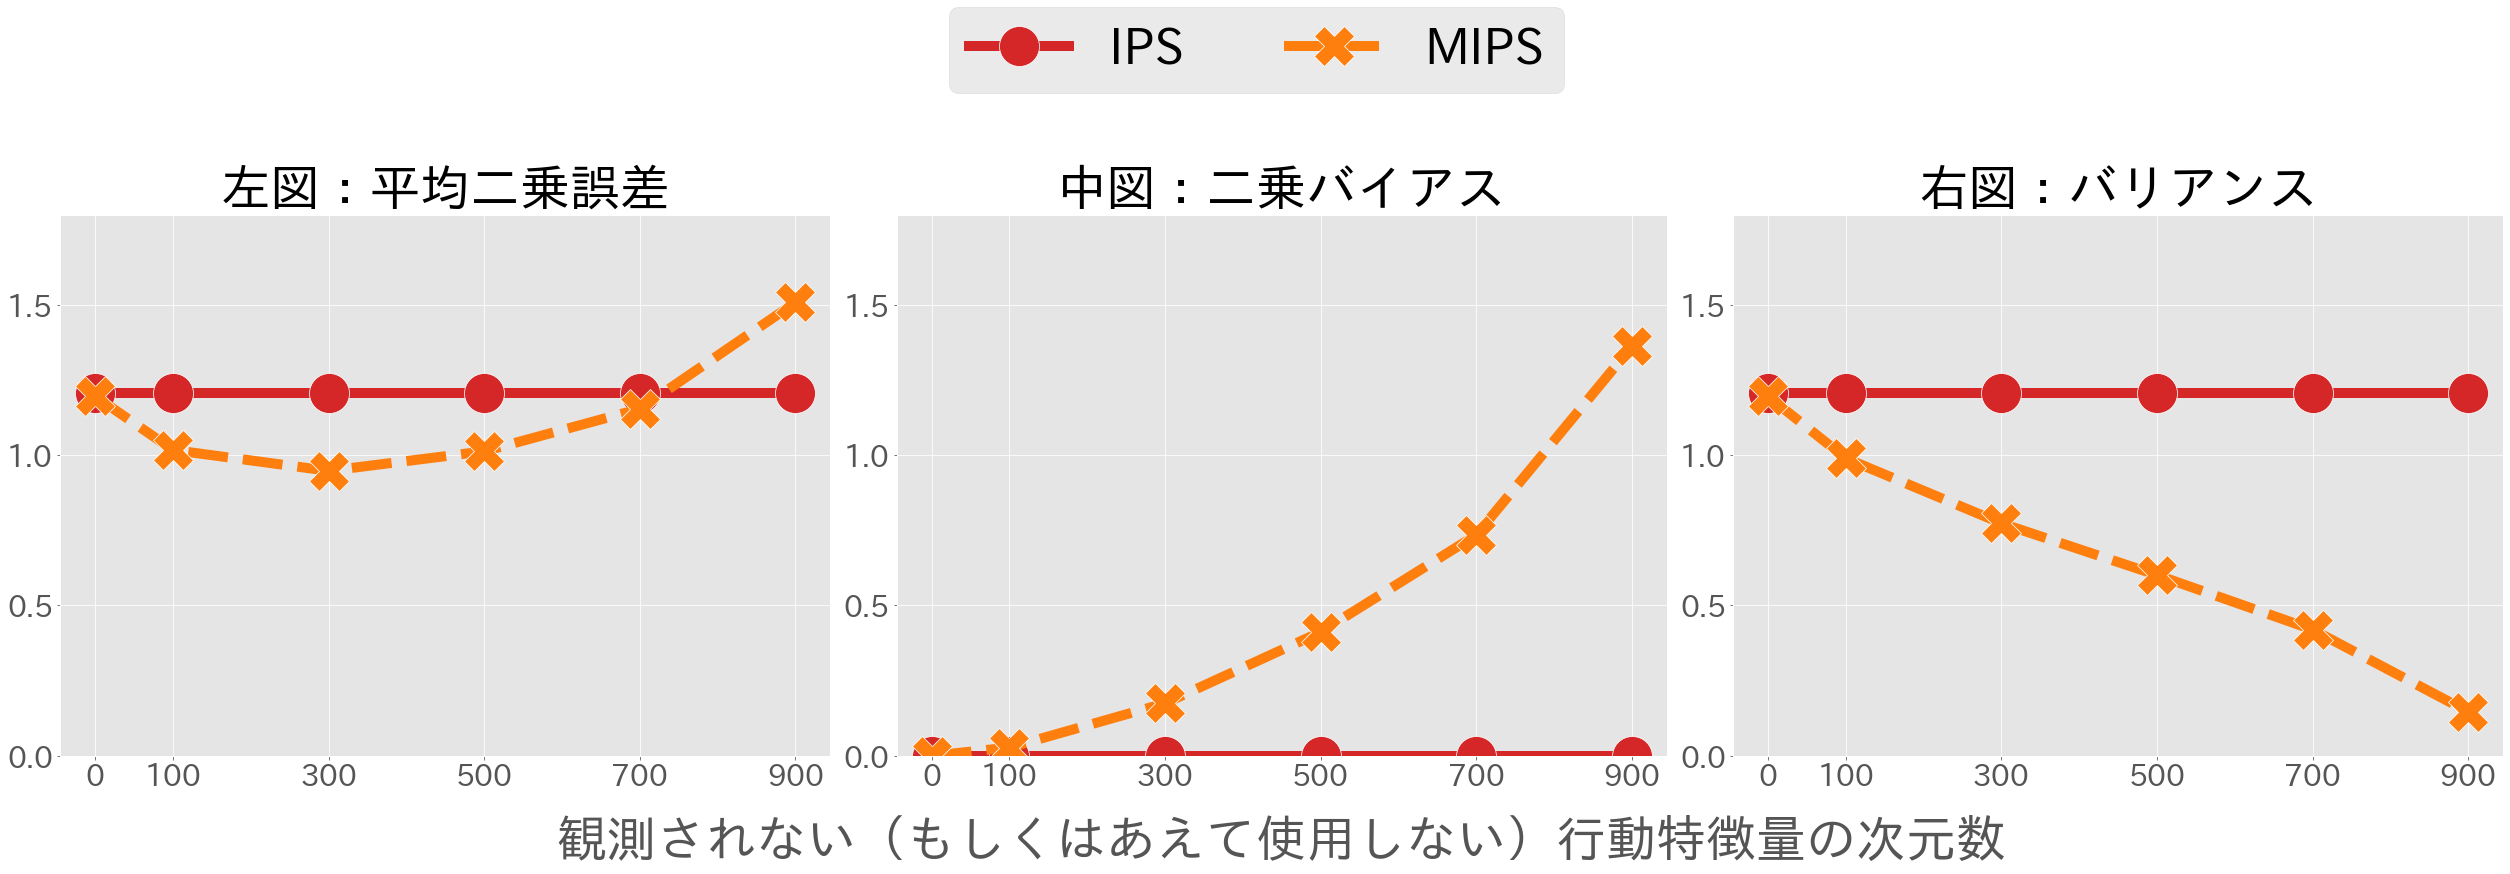

In [4]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_replace_clusters",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange"],
        data=result_df_num_replace_clusters.query("est != 'avg' and est != 'offcem'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 1.8)
    ax.set_yticks([0, 0.5, 1, 1.5])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"観測されない（もしくはあえて使用しない）行動特徴量の次元数", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_replace_clusters_list)
    ax.set_xticklabels(num_replace_clusters_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "MIPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")


## 図3.19

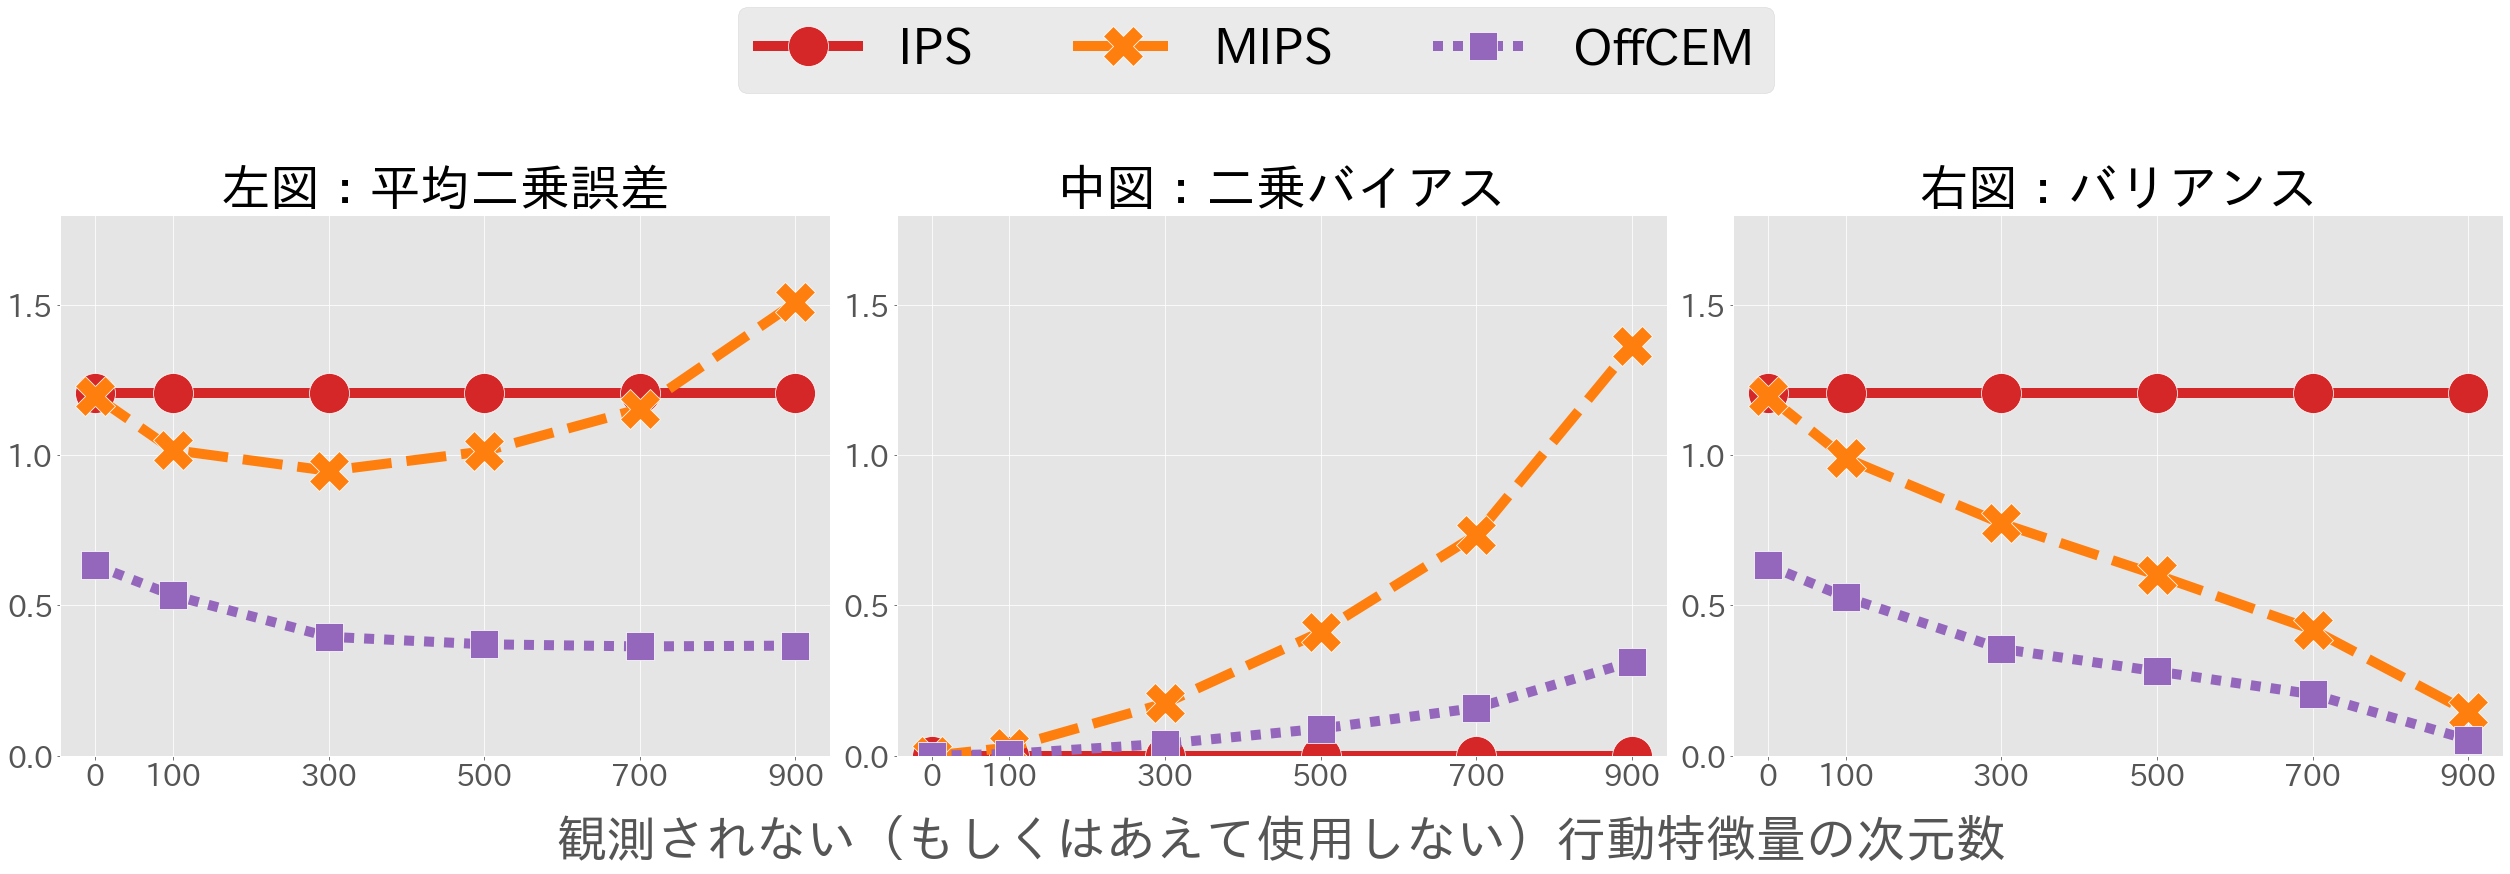

In [5]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_replace_clusters",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:purple"],
        data=result_df_num_replace_clusters.query("est != 'avg'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 1.8)
    ax.set_yticks([0, 0.5, 1, 1.5])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"観測されない（もしくはあえて使用しない）行動特徴量の次元数", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_replace_clusters_list)
    ax.set_xticklabels(num_replace_clusters_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "MIPS", "OffCEM"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")


### 行動数$|A|$を変化させたときのIPS・MIPS・OffCEM推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [6]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_data = 1000 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
lambda_ = 0.8 # クラスタ効果と残差効果の配合率
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [250, 500, 1000, 2000, 4000] # 行動数, |A|

In [7]:
result_df_list = []
for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    num_clusters = np.int(0.995 * num_actions) # 行動クラスタ数
    theta_g = random_.normal(size=(dim_context, num_clusters))
    M_g = random_.normal(size=(dim_context, num_clusters))
    b_g = random_.normal(size=(1, num_clusters))
    phi_a = random_.choice(num_clusters, size=num_actions)
    theta_h = random_.normal(size=(dim_context, num_actions))
    M_h = random_.normal(size=(dim_context, num_actions))
    b_h = random_.normal(size=(1, num_actions))

    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters,
        lambda_=lambda_, phi_a=phi_a,
        theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_, beta=beta,
            theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, random_state = _
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["q_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        q_hat = offline_logged_data["h_x_a"] + random_.normal(size=(num_data, num_actions))
        estimated_policy_values["ips"] = calc_ips(offline_logged_data, pi)
        estimated_policy_values["mips"] = calc_mips(offline_logged_data, pi)
        estimated_policy_values["mips (selection)"] = calc_mips(
            offline_logged_data, pi, replace_c=np.int(num_clusters / 2)
        )
        estimated_policy_values["offcem"] = calc_offcem(
            offline_logged_data, pi, q_hat, replace_c=np.int(num_clusters / 2)
        )
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)


num_actions=4000...: 100%|██████████| 1000/1000 [18:55<00:00,  1.14s/it]


## 図3.16

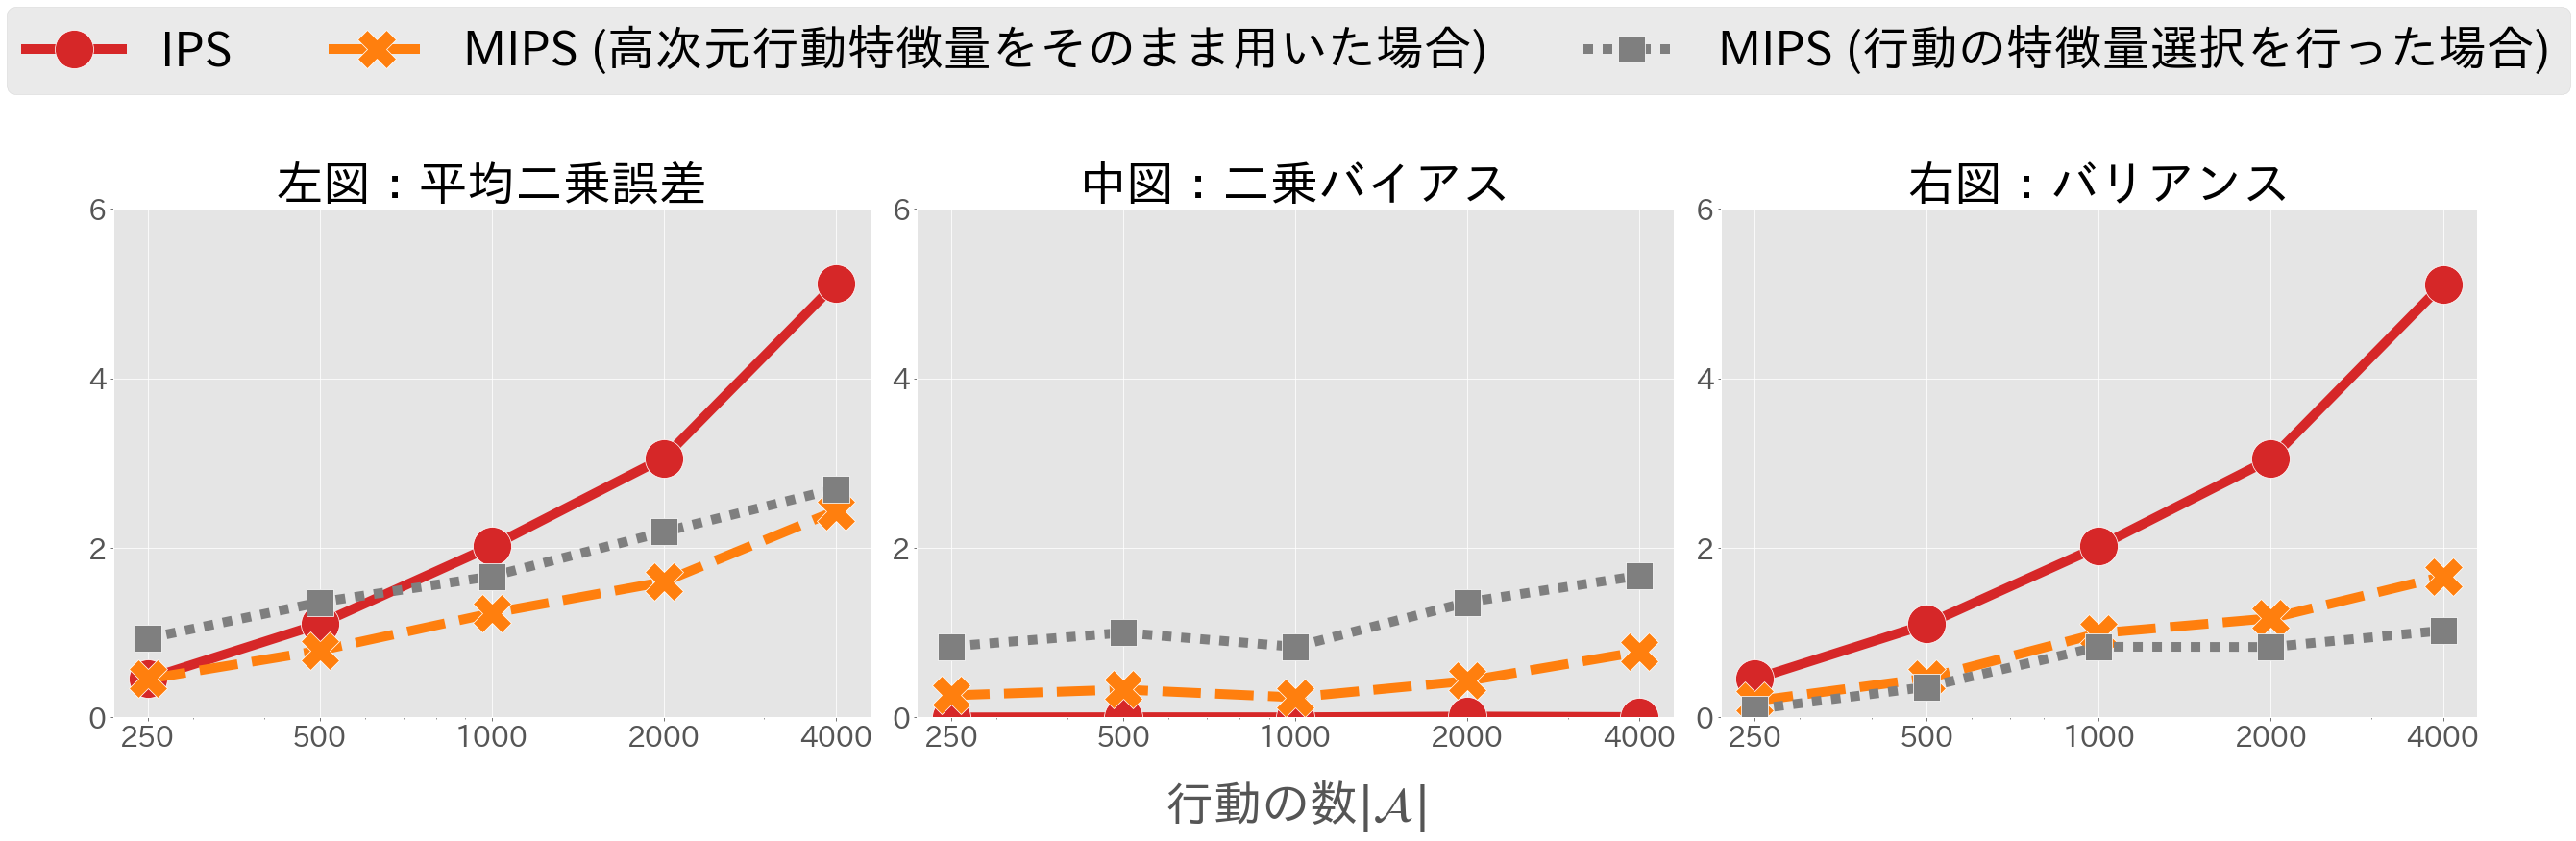

In [8]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
result_df_actions_ = remove_outliers(result_df_actions, ["ips", "mips", "offcem"])
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:grey"],
        data=result_df_actions_.query("est != 'offcem'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 6)
    ax.set_yticks([0, 2, 4, 6])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["IPS", "MIPS (高次元行動特徴量をそのまま用いた場合)", "MIPS (行動の特徴量選択を行った場合)"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center",
)


## 図3.20

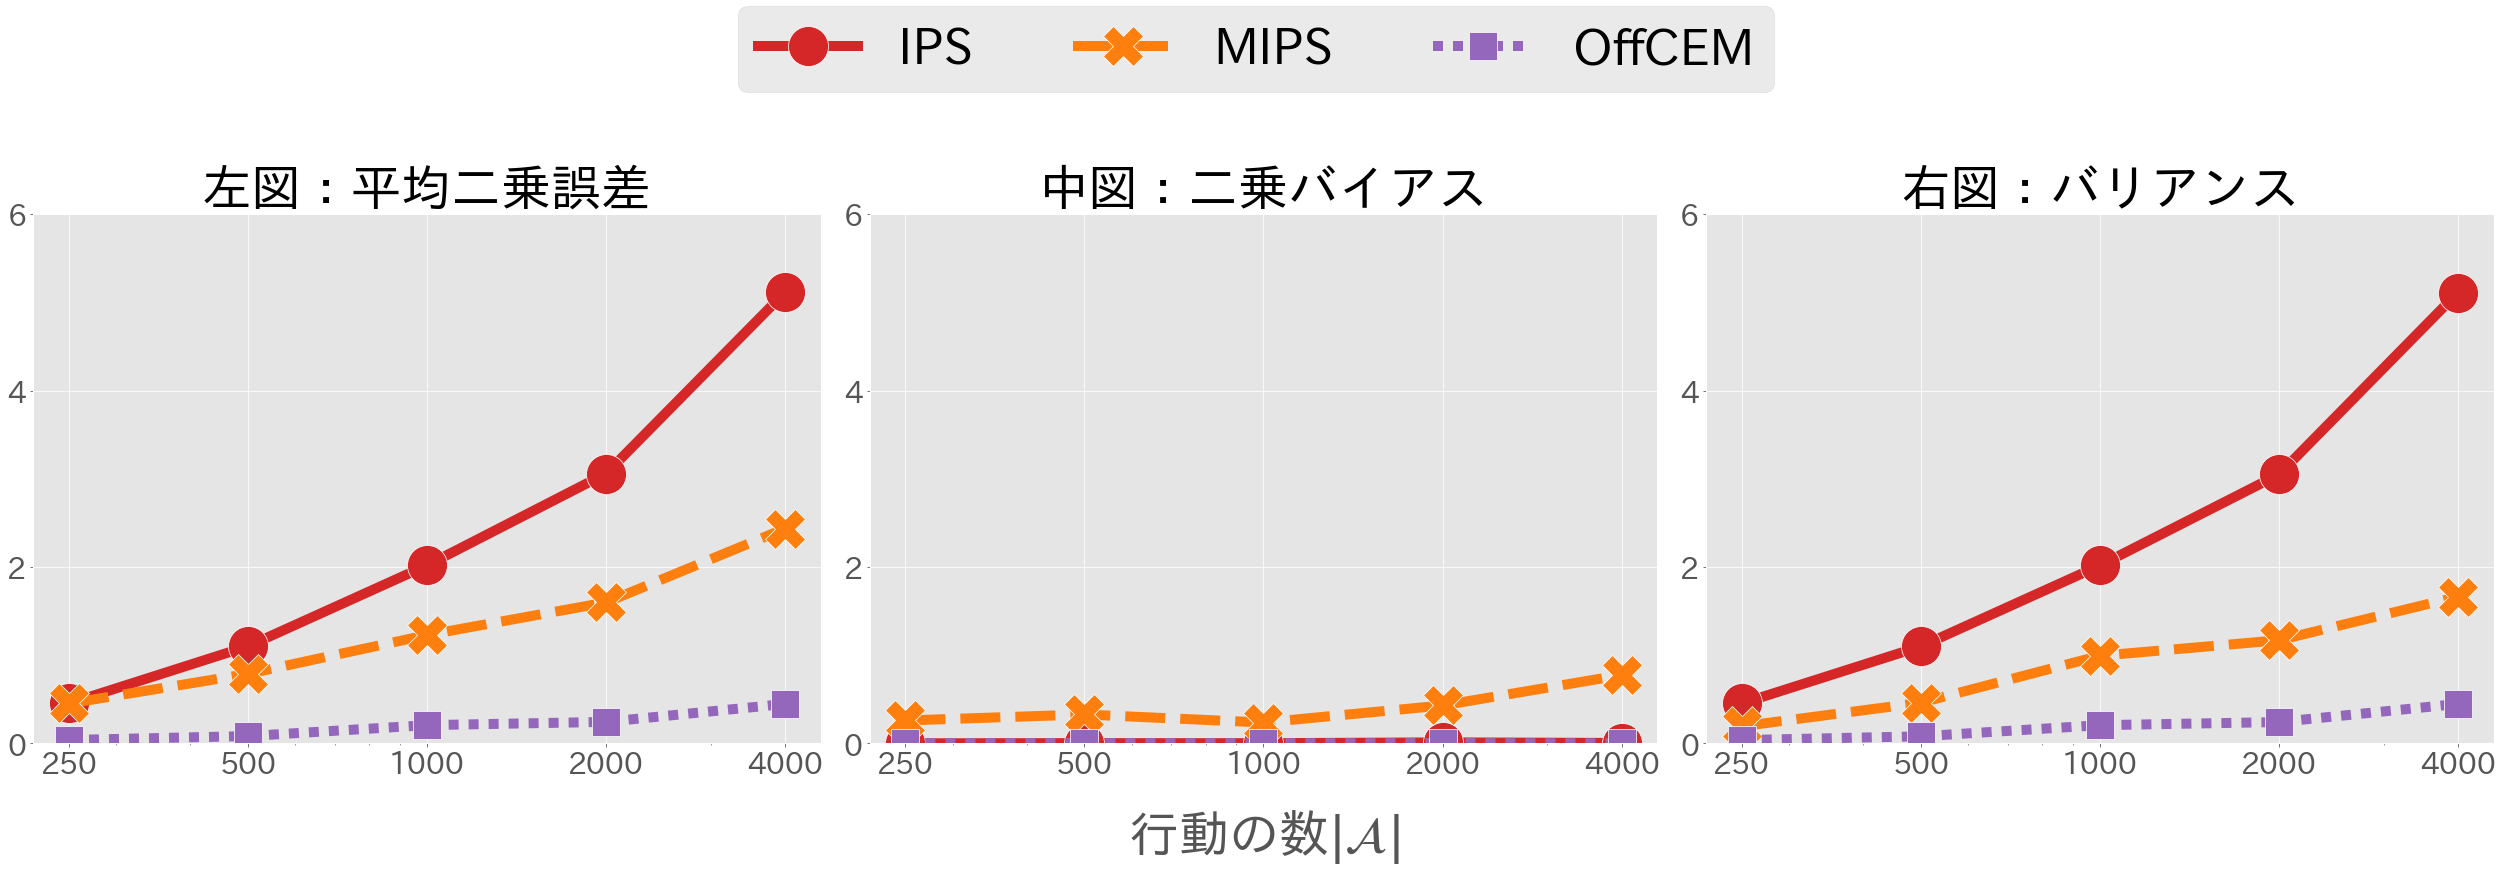

In [9]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:purple"],
        data=result_df_actions_.query("est != 'mips (selection)'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 6)
    ax.set_yticks([0, 2, 4, 6])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "MIPS", "OffCEM"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")


### ログデータのサイズ$n$を変化させたときのIPS・MIPS・OffCEM推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [10]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_actions = 500 # 行動数, |A|
num_clusters = 990 # 行動クラスタ数
beta = -0.2 # データ収集方策のパラメータ
lambda_ = 0.5 # クラスタ効果と残差効果の配合率
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000] # ログデータのサイズ

In [11]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
phi_a = random_.choice(num_clusters, size=num_actions)
theta_g = random_.normal(size=(dim_context, num_clusters))
M_g = random_.normal(size=(dim_context, num_clusters))
b_g = random_.normal(size=(1, num_clusters))
theta_h = random_.normal(size=(dim_context, num_actions))
M_h = random_.normal(size=(dim_context, num_actions))
b_h = random_.normal(size=(1, num_actions))
for num_data in num_data_list:
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters,
        lambda_=lambda_, phi_a=phi_a,
        theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, lambda_=lambda_, beta=beta,
            theta_g=theta_g, M_g=M_g, b_g=b_g, theta_h=theta_h, M_h=M_h, b_h=b_h, phi_a=phi_a,
            dim_context=dim_context, num_actions=num_actions, num_clusters=num_clusters, random_state = _,
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["q_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        q_hat = offline_logged_data["h_x_a"] + random_.normal(size=(num_data, num_actions))
        estimated_policy_values["ips"] = calc_ips(offline_logged_data, pi)
        estimated_policy_values["mips"] = calc_mips(offline_logged_data, pi)
        estimated_policy_values["mips (selection)"] = calc_mips(offline_logged_data, pi, replace_c=200)
        estimated_policy_values["offcem"] = calc_offcem(offline_logged_data, pi, q_hat, replace_c=200)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)


num_data=4000...: 100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


## 図3.17

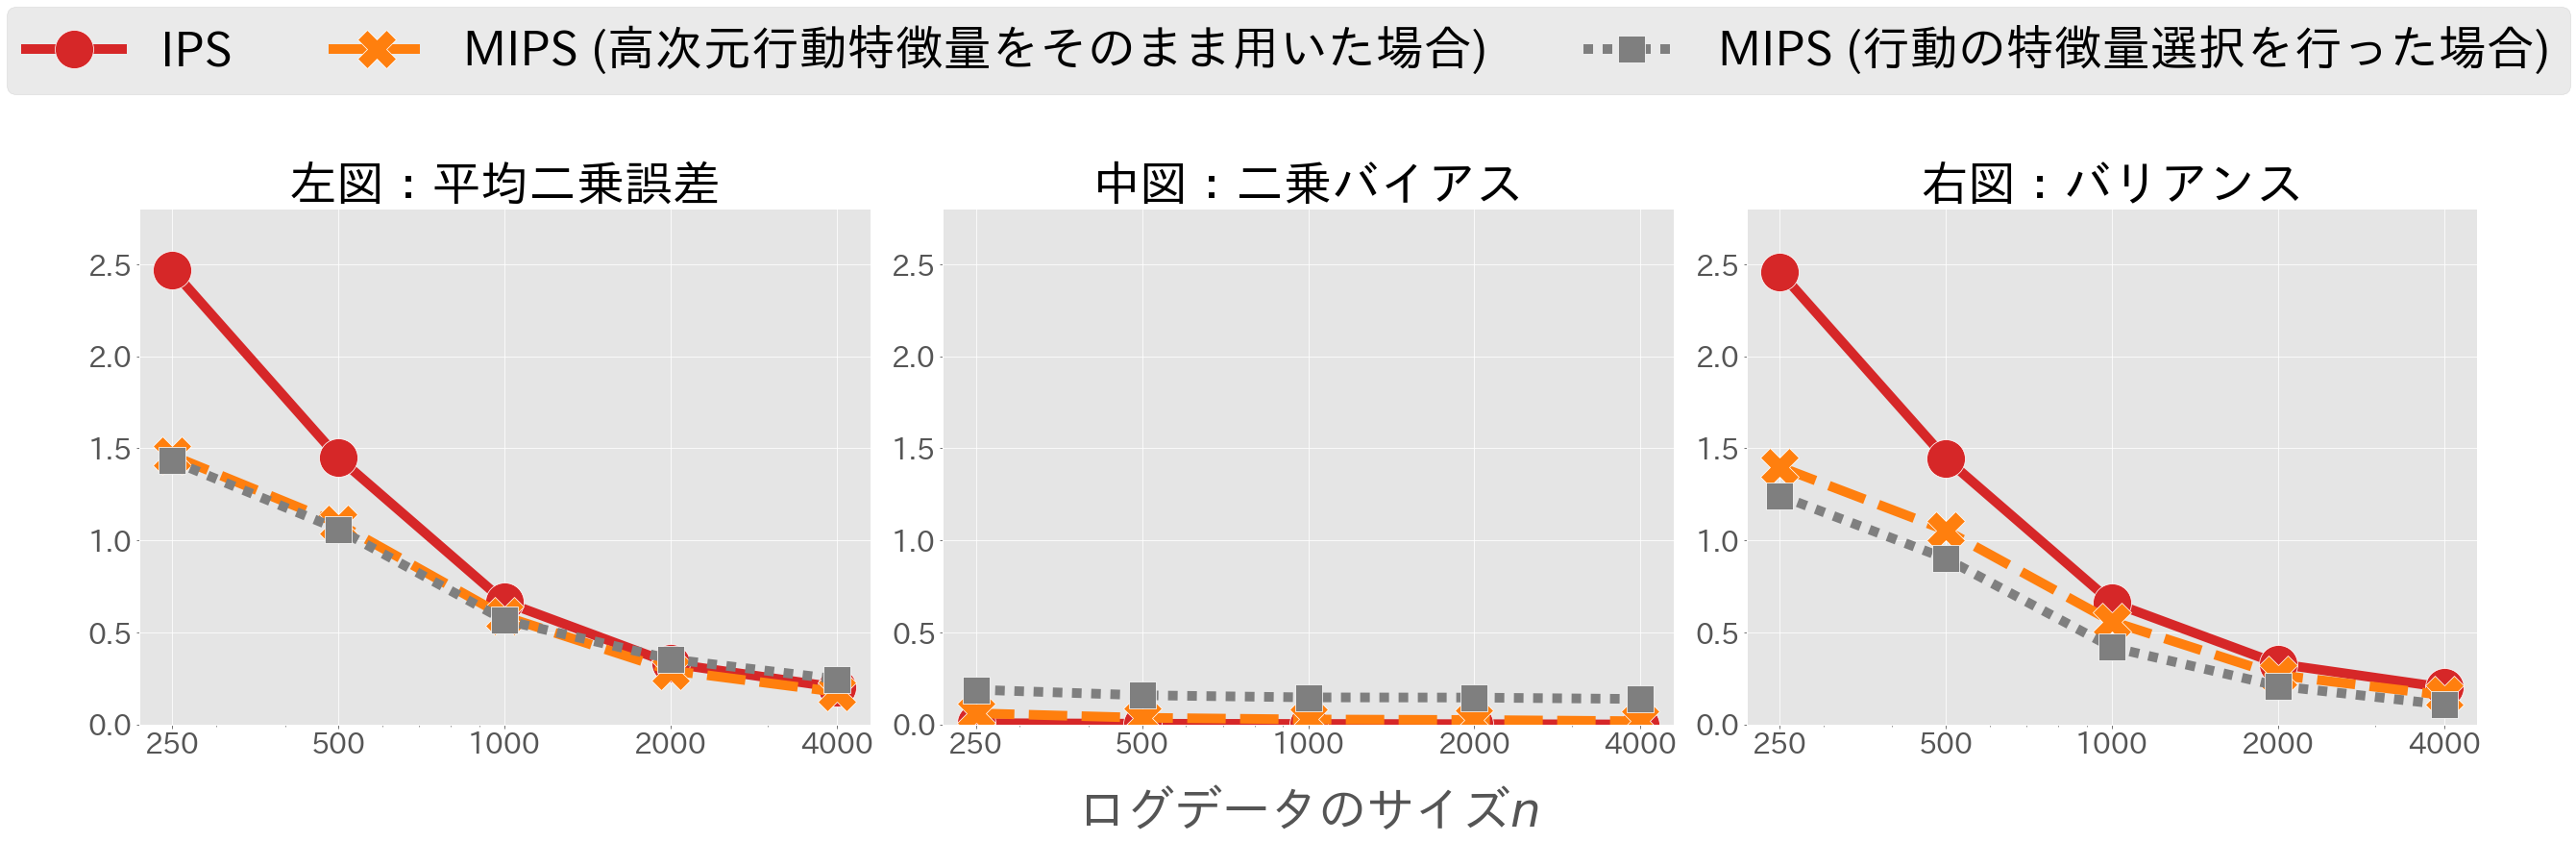

In [12]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:grey"],
        data=result_df_data.query("est != 'offcem'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 2.8)
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["IPS", "MIPS (高次元行動特徴量をそのまま用いた場合)", "MIPS (行動の特徴量選択を行った場合)"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center",
)


## 図3.21

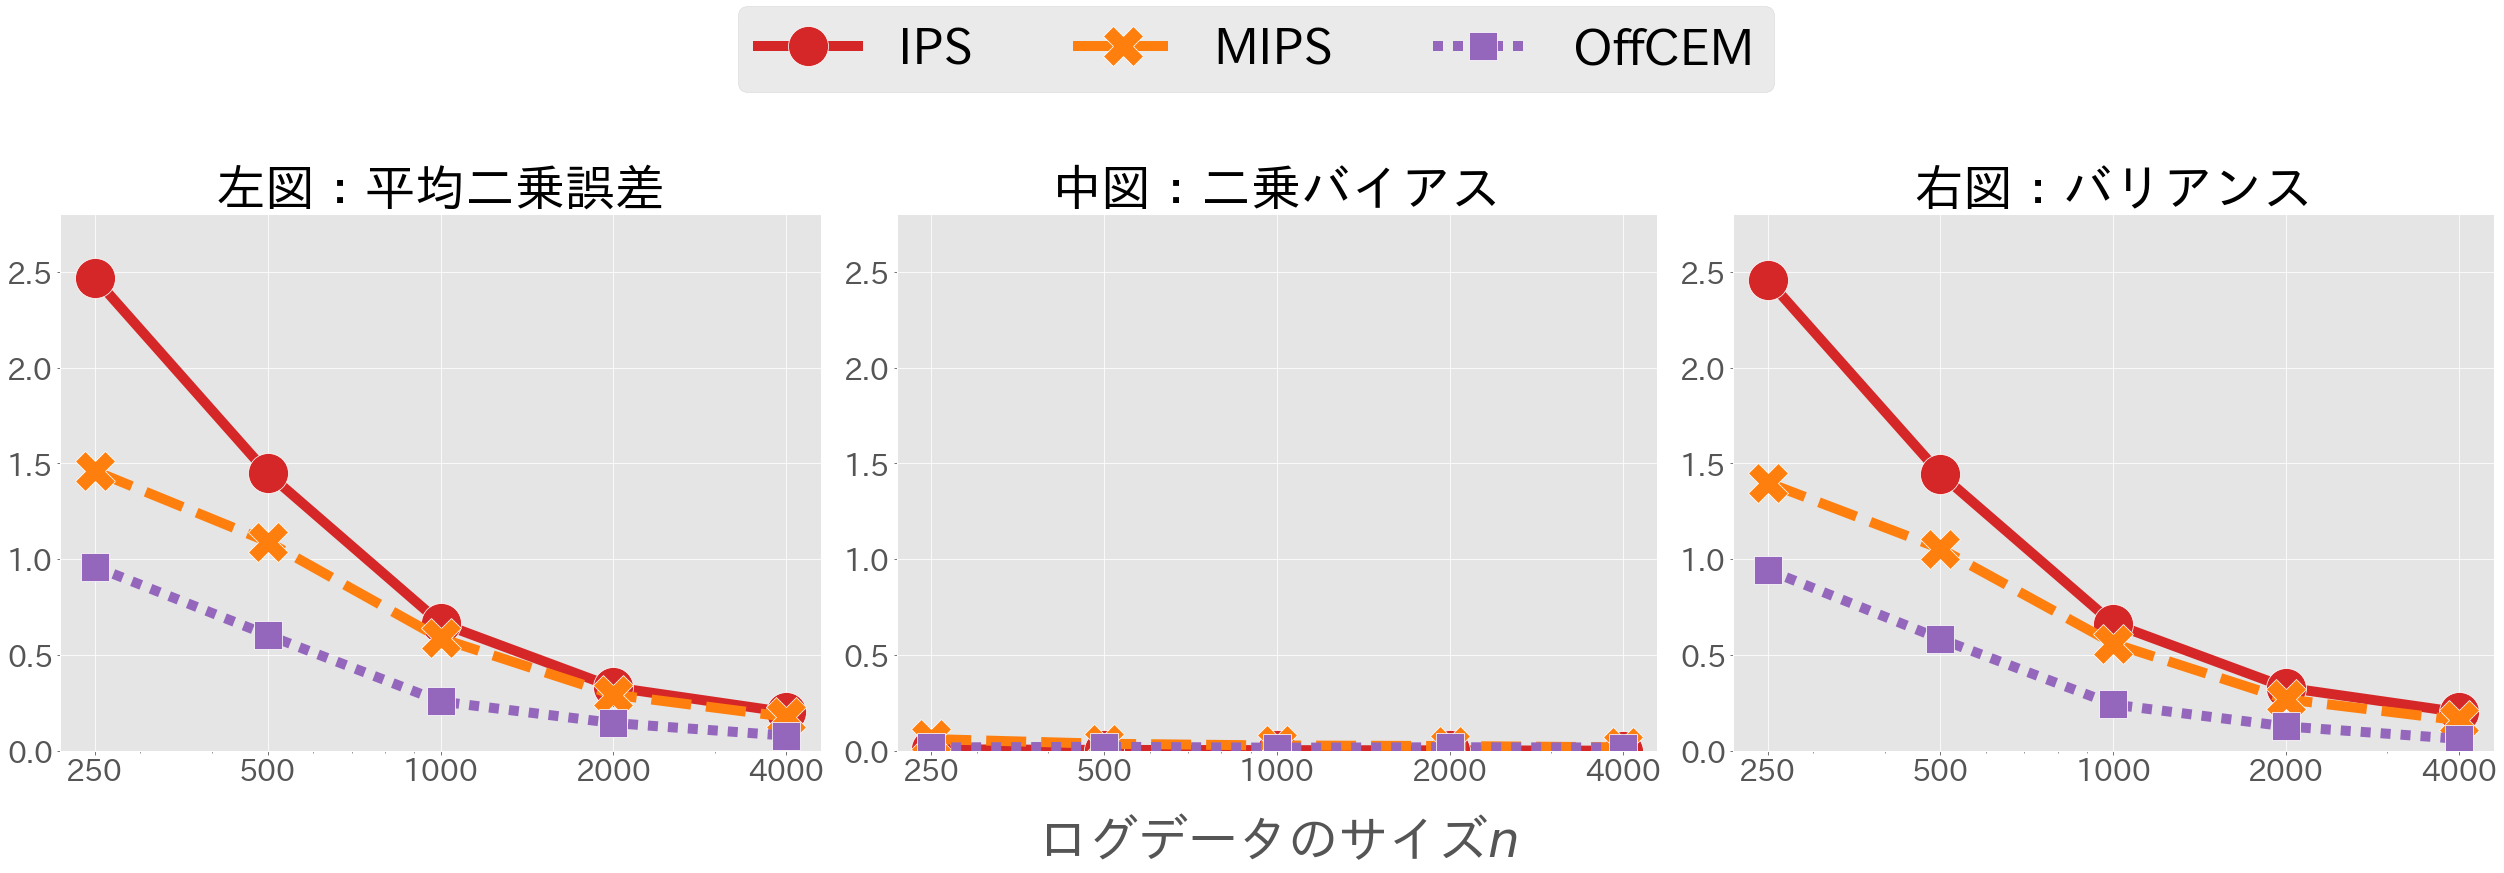

In [13]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=10,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:purple"],
        data=result_df_data.query("est != 'mips (selection)'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 2.8)
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["IPS", "MIPS", "OffCEM"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")
